# CIFAR-10 Image Classification

### Problem: classify CIFAR-10 images (10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck).

In [1]:
 import os
import random
from pathlib import Path
from typing import Tuple, Dict, Any

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# reproducibility
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [4]:
set_seed(42)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [6]:
# Data config
DATA_DIR = "./data"
BATCH_SIZE = 128
NUM_WORKERS = 4

In [7]:
# CIFAR-10 normalization constants (computed from training set)
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD  = (0.2470, 0.2435, 0.2616)

In [8]:
# Transforms
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

In [9]:
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

In [10]:
# Load dataset
full_train = datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=train_transform)
test_set = datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=test_transform)

100%|██████████| 170M/170M [00:03<00:00, 48.5MB/s]


In [11]:
# Train/val split
val_size = 5000
train_size = len(full_train) - val_size
train_set, val_set = random_split(full_train, [train_size, val_size],
                                  generator=torch.Generator().manual_seed(42))

In [12]:
# For validation use test_transform (no augmentation)
val_set.dataset.transform = test_transform

In [13]:
# DataLoaders
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [14]:
# class names
classes = full_train.classes
print("Classes:", classes)
print("Train/Val/Test sizes:", len(train_set), len(val_set), len(test_set))

Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Train/Val/Test sizes: 45000 5000 10000


Visualize random batch samples

In [15]:
# helper for de-normalizing and plotting
inv_normalize = transforms.Normalize(
    mean=[-m/s for m, s in zip(CIFAR10_MEAN, CIFAR10_STD)],
    std=[1/s for s in CIFAR10_STD]
)

In [16]:
def show_batch(loader, nrows=3, ncols=6):
    images, labels = next(iter(loader))
    images = images[:nrows*ncols]
    images = [inv_normalize(img).permute(1,2,0).numpy() for img in images]
    plt.figure(figsize=(ncols*1.5, nrows*1.5))
    for i, img in enumerate(images):
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(np.clip(img, 0, 1))
        plt.axis('off')
        plt.title(classes[labels[i]])
    plt.tight_layout()
    plt.show()

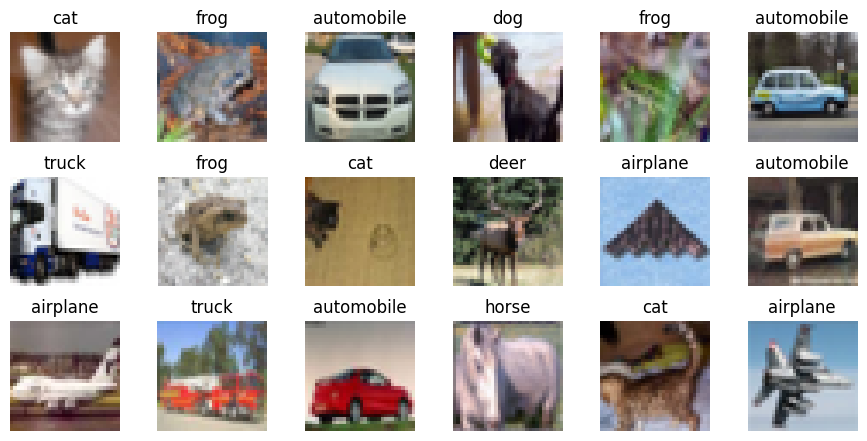

In [17]:
show_batch(train_loader)

In [18]:
from collections import Counter

In [19]:
def dataset_class_distribution(dataset):
    # dataset may be Subset -> access dataset.dataset.targets
    if hasattr(dataset, "dataset"):  # Subset
        targets = np.array(dataset.dataset.targets)[dataset.indices]
    else:
        targets = np.array(dataset.targets)
    counts = Counter(targets.tolist())
    return [counts[i] for i in range(len(classes))]

In [20]:
print("Train distribution:", dataset_class_distribution(train_set))
print("Val distribution:", dataset_class_distribution(val_set))
print("Test distribution:", dataset_class_distribution(test_set))

Train distribution: [4512, 4488, 4468, 4529, 4529, 4486, 4493, 4500, 4496, 4499]
Val distribution: [488, 512, 532, 471, 471, 514, 507, 500, 504, 501]
Test distribution: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


Model Architecture — Custom CNN

In [21]:
import torch.nn.functional as F

In [22]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel=3, padding=1, pool=True, dropout=0.0):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=kernel, padding=padding, bias=False)
        self.bn = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(2) if pool else nn.Identity()
        self.dropout = nn.Dropout2d(dropout) if dropout>0 else nn.Identity()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout(x)
        return x

In [24]:
class SimpleCIFARNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # Convolutional feature extractor
        self.features = nn.Sequential(
            ConvBlock(3, 64, pool=True, dropout=0.05),    # 32 -> 16
            ConvBlock(64, 128, pool=True, dropout=0.1),   # 16 -> 8
            ConvBlock(128, 256, pool=True, dropout=0.15), # 8 -> 4
            ConvBlock(256, 512, pool=False, dropout=0.2), # keep 4x4
        )
        # Global average pooling and classifier
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256, bias=False),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        x = self.classifier(x)
        return x

In [25]:
model = SimpleCIFARNet(num_classes=10).to(device)
print(model)

SimpleCIFARNet(
  (features): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (dropout): Dropout2d(p=0.05, inplace=False)
    )
    (1): ConvBlock(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (dropout): Dropout2d(p=0.1, inplace=False)
    )
    (2): ConvBlock(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running

Training Loop, Loss, Optimizer, Scheduler, Callbacks

In [26]:
import time
from sklearn.metrics import accuracy_score, confusion_matrix
import torch.nn as nn

In [27]:
def save_checkpoint(state, filename):
    torch.save(state, filename)

In [28]:
class EarlyStopping:
    def __init__(self, patience=10, delta=0.0):
        self.patience = patience
        self.delta = delta
        self.best_loss = float('inf')
        self.counter = 0
        self.should_stop = False

    def step(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            return True  # improved
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True
            return False

In [29]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds, all_targets = [], []
    for images, targets in loader:
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1).detach().cpu().numpy()
        all_preds.append(preds)
        all_targets.append(targets.detach().cpu().numpy())
    avg_loss = running_loss / len(loader.dataset)
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    acc = (all_preds == all_targets).mean()
    return avg_loss, acc

In [30]:
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds, all_targets = [], []
    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)
            outputs = model(images)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1).detach().cpu().numpy()
            all_preds.append(preds)
            all_targets.append(targets.detach().cpu().numpy())
    avg_loss = running_loss / len(loader.dataset)
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    acc = (all_preds == all_targets).mean()
    return avg_loss, acc, all_preds, all_targets

Full training run

In [31]:
def run_training(model, train_loader, val_loader, device, epochs=60, out_dir="./outputs"):
    os.makedirs(out_dir, exist_ok=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    earlystop = EarlyStopping(patience=10)
    best_val_loss = float('inf')
    history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}

    for epoch in range(1, epochs+1):
        t0 = time.time()
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, _, _ = validate(model, val_loader, criterion, device)
        scheduler.step()
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        improved = val_loss < best_val_loss
        if improved:
            best_val_loss = val_loss
            save_checkpoint({
                'epoch': epoch,
                'model_state': model.state_dict(),
                'optimizer_state': optimizer.state_dict(),
                'val_loss': val_loss,
            }, os.path.join(out_dir, "best_checkpoint.pth"))

        earlystop.step(val_loss)
        print(f"Epoch {epoch:03d}/{epochs} | train_loss={train_loss:.4f} acc={train_acc:.4f} | "
              f"val_loss={val_loss:.4f} acc={val_acc:.4f} | time={(time.time()-t0):.1f}s")
        if earlystop.should_stop:
            print("Early stopping triggered.")
            break
    return history

In [32]:
history = run_training(model, train_loader, val_loader, device, epochs=60, out_dir="./outputs")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 001/60 | train_loss=1.6112 acc=0.4170 | val_loss=1.2121 acc=0.5536 | time=14.8s
Epoch 002/60 | train_loss=1.2119 acc=0.5606 | val_loss=1.0104 acc=0.6306 | time=15.1s
Epoch 003/60 | train_loss=1.0340 acc=0.6300 | val_loss=0.8349 acc=0.7060 | time=15.1s
Epoch 004/60 | train_loss=0.9228 acc=0.6739 | val_loss=0.7517 acc=0.7376 | time=19.0s
Epoch 005/60 | train_loss=0.8314 acc=0.7099 | val_loss=0.7007 acc=0.7484 | time=17.2s
Epoch 006/60 | train_loss=0.7588 acc=0.7335 | val_loss=0.6469 acc=0.7722 | time=15.5s
Epoch 007/60 | train_loss=0.6923 acc=0.7570 | val_loss=0.6590 acc=0.7674 | time=17.1s
Epoch 008/60 | train_loss=0.6423 acc=0.7752 | val_loss=0.6473 acc=0.7698 | time=12.6s
Epoch 009/60 | train_loss=0.5856 acc=0.7961 | val_loss=0.5869 acc=0.7990 | time=14.4s
Epoch 010/60 | train_loss=0.5433 acc=0.8088 | val_loss=0.5459 acc=0.8026 | time=12.6s
Epoch 011/60 | train_loss=0.4980 acc=0.8264 | val_loss=0.5140 acc=0.8204 | time=12.5s
Epoch 012/60 | train_loss=0.4551 acc=0.8399 | val_loss

Plot Training Curves

In [33]:
def plot_history(history):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history["train_loss"], label="train")
    plt.plot(history["val_loss"], label="val")
    plt.title("Loss")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history["train_acc"], label="train")
    plt.plot(history["val_acc"], label="val")
    plt.title("Accuracy")
    plt.legend()
    plt.show()

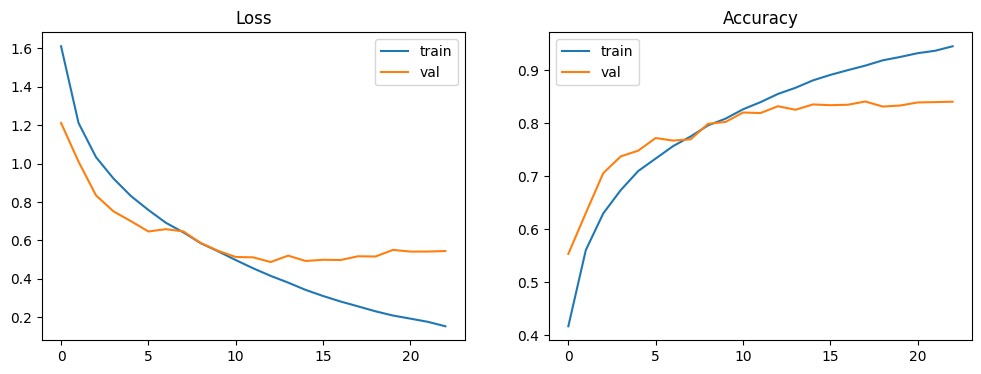

In [34]:
plot_history(history)

Evaluation — Confusion Matrix, Metrics, Sample Predictions

In [35]:
ckpt = torch.load("./outputs/best_checkpoint.pth", map_location=device)
model.load_state_dict(ckpt['model_state'])
model.to(device)
model.eval()

SimpleCIFARNet(
  (features): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (dropout): Dropout2d(p=0.05, inplace=False)
    )
    (1): ConvBlock(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (dropout): Dropout2d(p=0.1, inplace=False)
    )
    (2): ConvBlock(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running

In [36]:
# evaluate on test set
test_loss, test_acc, preds, targets = validate(model, test_loader, nn.CrossEntropyLoss(), device)
print("Test loss:", test_loss, "Test acc:", test_acc)

Test loss: 0.5071291944980622 Test acc: 0.8272


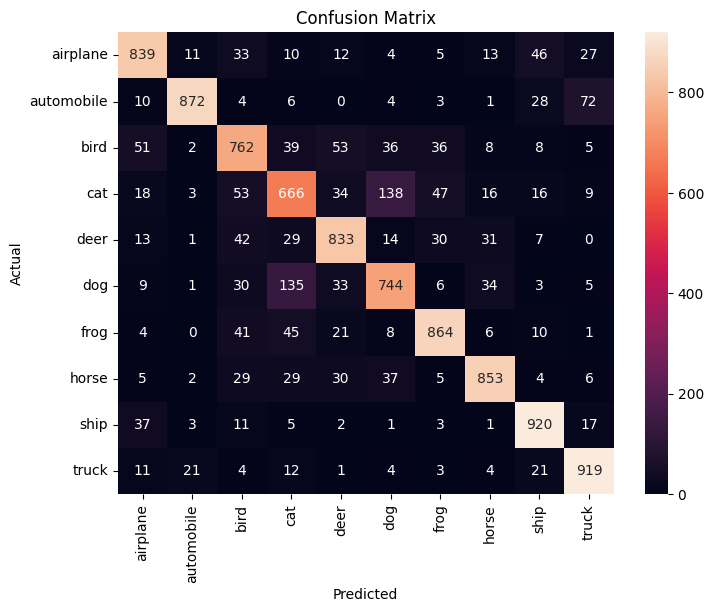

In [37]:
# confusion matrix
cm = confusion_matrix(targets, preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Sample predictions visualization

In [38]:
def show_predictions(model, loader, n=12):
    images, labels = next(iter(loader))
    images_show = images[:n]
    labels_show = labels[:n]
    model.eval()
    with torch.no_grad():
        outputs = model(images_show.to(device))
        preds = outputs.argmax(dim=1).cpu().numpy()
    imgs = [inv_normalize(img).permute(1,2,0).numpy() for img in images_show]
    plt.figure(figsize=(n//6*3, 6))
    for i, img in enumerate(imgs):
        plt.subplot(2, n//2, i+1)
        plt.imshow(np.clip(img, 0, 1))
        plt.title(f"P:{classes[preds[i]]}\nT:{classes[labels_show[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


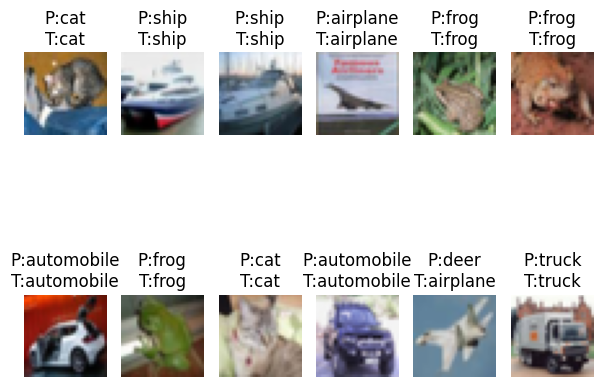

In [39]:
show_predictions(model, test_loader)

In [40]:
torch.save(model.state_dict(), "cifar10_model_state.pth")